In [1]:
import numpy as np
#此方法没有步长和质量矩阵参数：分别有beta，covarience参数自适应调整

def deterministicR(inIndex,q): 
    """
    Parameters: 
      * inIndex  : index of the posterior values  
      * q  : weight of the posterior values 
      
    Output: 
      * outindx  : index of the resampling  
    """
    
    n_chains = inIndex.shape[0]
    parents = np.arange(n_chains)
    N_childs = np.zeros(n_chains, dtype=int)

    cum_dist = np.cumsum(q)
    aux = np.random.rand(1)
    u = parents + aux
    u /= n_chains
    j = 0
    for i in parents:
        while u[i] > cum_dist[j]:
            j += 1
        N_childs[j] += 1

    indx = 0
    outindx = np.zeros(n_chains, dtype=int)
    for i in parents:
        if N_childs[i] > 0:
            for j in range(indx, (indx + N_childs[i])):
                outindx[j] = parents[i]

        indx += N_childs[i]

    return outindx

def AMH(X, target, covariance, mrun, beta, LB, UB, burn_in=0):
    """
    Adaptive Metropolis algorithm
    scales the covariance matrix according to the acceptance rate 
    cov of proposal = (a+ bR)*sigma;  R = acceptance rate
    returns the last sample of the chain
    
    Parameters: 
     *  X : starting model 
     *  target : target distribution (is a function handle and calculates the log posterior)
     *  covariance : covariance of the proposal distribution 
     *  mrun : number of samples 
     *  beta : use the beta parameter of SMC sampling, otherwise 1 
     *  LB : lower bound of the model parameters
     *  UB : upper bound of the model parameters
    
    Outputs: 
     *  G : last sample of the chain 
     *  GP : log posterior value of the last sample 
     *  avg_acc : average acceptance rate
     
     written by : Rishabh Dutta (18 Mar 2019)
     Matlab version written on 12 Mar 2016
     (Don't forget to acknowledge)
    """
    
    
    """
    新增参数:
        burn_in : 预热期比例 (0.0~1.0)，默认丢弃前20%的迭代样本
    """
    Dims = covariance.shape[0]
    burn_in_steps = int(mrun * burn_in)
    total_steps = mrun + burn_in_steps  # 总迭代次数 = 正式迭代 + 预
    # 存储所有样本（包括预热）
    TH = np.zeros((Dims, mrun))
    THP = np.zeros((1, mrun))
    factor = np.zeros((1, mrun))
    U = np.log(np.random.rand(1, total_steps))
    logpdf = target(X)
    V = covariance
    best_P = logpdf * beta
    P0 = logpdf * beta
    a, b = 1/9, 8/9
    sameind = np.where(np.equal(LB, UB))
    avg_acc = 0
    def dimension(i):
        switcher={
            1:0.441,
            2:0.352,
            3:0.316,
            4:0.285,
            5:0.275,
            6:0.273,
            7:0.270,
            8:0.268,
            9:0.267,
            10:0.266,
            11:0.265,
            12:0.255            
            }
        return switcher.get(i, 0.255)
    
    # set initial scaling factor
    s = a + b*dimension(Dims)
    for i in range(total_steps):
        # ...原有MCMC逻辑（生成新样本、计算接受率等）...
        X_new = np.random.multivariate_normal(X,s**2*V)
        X_new[sameind] = LB[sameind]
        
        ind1 = np.where(X_new < LB)
        diff1 = LB[ind1] - X_new[ind1]
        X_new[ind1] = LB[ind1] + diff1 
        
        if avg_acc < 0.05: 
            X_new[ind1] = LB[ind1]
            
        ind2 = np.where(X_new > UB)
        diff2 = X_new[ind2] - UB[ind2]
        X_new[ind2] = UB[ind2] - diff2
        
        if avg_acc < 0.05:
            X_new[ind2] = UB[ind2]
            
        P_new = beta * target(X_new)
        
        if P_new > best_P: 
            X = X_new
            best_P = P_new
            P0 = P_new
            acc_rate = 1 
        else:
            rho = P_new - P0 
            acc_rate = np.exp(np.min([0,rho]))
            if U[0,i] <= rho : 
                X = X_new
                P0 = P_new
        # 仅保留预热后的样本
        if i >= burn_in_steps:
            TH[:, i - burn_in_steps] = np.transpose(X)
            THP[0, i - burn_in_steps] = P0
            factor[0, i - burn_in_steps] = s**2
    
    G = TH[:, -1]
    GP = THP[0, -1] / beta
    return G, GP, avg_acc
    
    
# %%
class SMCclass:
    """
    Generates samples of the 'target' posterior PDF using SMC sampling. Also called Adapative Transitional Metropolis
    Importance (sampling) P abbreviated as ATMIP  
    """
    def __init__(self, opt, samples, NT1, NT2, verbose=True):
        """
        Parameters: 
            opt : named tuple 
                - opt.target (lamda function of the posterior)
                - opt.UB (upper bound of parameters)
                - opt.LB (lower bound of parameters)
                - opt.N (number of Markov chains at each stage)
                - opt.Neff (Chain length of the MCMC sampling) 
                
            samples: named tuple
                - samples.allsamples (samples at each stage)
                - samples.postval (log posterior value of samples)
                - samples.beta (array of beta values)
                - samples.stage (array of stages)
                - samples.covsmpl (model covariance at each stage)
                - samples.resmpl (resampled model at each stage)
                
            NT1: create opt object
            NT2: create samples object 
            
        written by: Rishabh Dutta, Dec 12 2018
        (Don't forget to acknowledge)
        
        """
        self.verbose = verbose
        self.opt = opt  
        self.samples = samples
        self.NT1 = NT1
        self.NT2 = NT2
            
    def initialize(self):
        if self.verbose:
            print ("-----------------------------------------------------------------------------------------------")
            print ("-----------------------------------------------------------------------------------------------")
            print(f'Initializing ATMIP with {self.opt.N :8d} Markov chains and {self.opt.Neff :8d} chain length.')
                    
    def prior_samples(self):
        '''
        determines the prior posterior values 
        the prior samples are estimated from lower and upper bounds
        
        Output : samples (NT2 object with estimated posterior values)
        '''
        numpars = self.opt.LB.shape[0]
        diffbnd = self.opt.UB - self.opt.LB
        diffbndN = np.tile(diffbnd,(self.opt.N,1))
        LBN = np.tile(self.opt.LB,(self.opt.N,1))
        
        sampzero = LBN +  np.random.rand(self.opt.N,numpars) * diffbndN
        beta = np.array([0]) 
        stage = np.array([1]) 
        
        postval = np.zeros([self.opt.N,1])
        for i in range(self.opt.N):
            samp0 = sampzero[i,:]
            logpost = self.opt.target(samp0)
            postval[i] = logpost
            
        samples = self.NT2(sampzero, postval, beta, stage, None, None)
        return samples
          
    
    def find_beta(self): 
        """
        Calculates the beta parameter for the next stage
        """
        beta1 = self.samples.beta[-1]       #prev_beta
        beta2 = self.samples.beta[-1]       #prev_beta
        max_post = np.max(self.samples.postval) 
        logpst = self.samples.postval - max_post
        beta = beta1+.5
    
        if beta>1:
            beta = 1
            #logwght = beta.*logpst
            #wght = np.exp(logwght)
    
        refcov = 1 
    
        while beta - beta1 > 1e-6:
            curr_beta = (beta+beta1)/2
            diffbeta = beta-beta1
            logwght = diffbeta*logpst
            wght = np.exp(logwght)
            covwght = np.std(wght)/np.mean(wght)
            if covwght > refcov:
                beta = curr_beta
            else:
                beta1 = curr_beta
            
        betanew = np.min(np.array([1,beta]))
        betaarray = np.append(self.samples.beta,betanew)
        newstage = np.arange(1,self.samples.stage[-1]+2)
        samples = self.NT2(self.samples.allsamples, self.samples.postval, \
                           betaarray, newstage, self.samples.covsmpl, \
                           self.samples.resmpl)
    
        return samples
    
    def resample_stage(self):
        '''
        Resamples the model samples at a certain stage 
        Uses Kitagawa's deterministic resampling algorithm
        '''
        
        # calculate the weight for model samples
        logpst = self.samples.postval - np.max(self.samples.postval)
        logwght = (self.samples.beta[-1] - self.samples.beta[-2])* logpst
        wght = np.exp(logwght)
        
        probwght = wght/np.sum(wght)
        inind = np.arange(0,self.opt.N)
        
        outind = deterministicR(inind, probwght)
        newsmpl = self.samples.allsamples[outind,:]
        
        samples = self.NT2(self.samples.allsamples, self.samples.postval, \
                           self.samples.beta, self.samples.stage, \
                           self.samples.covsmpl, newsmpl)
        
        return samples
        
    def make_covariance(self):
        '''
        make the model covariance using the weights and samples from previous 
        stage
        '''
        # calculate the weight for model samples
        
        dims = self.samples.allsamples.shape[1]
        logpst = self.samples.postval - np.max(self.samples.postval)
        logwght = (self.samples.beta[-1] - self.samples.beta[-2])* logpst
        wght = np.exp(logwght)
        
        probwght = wght/np.sum(wght)
        weightmat = np.tile(probwght,(1,dims))
        multmat = weightmat * self.samples.allsamples
        
        # calculate the mean samples
        meansmpl = multmat.sum(axis=0, dtype='float')
        
        # calculate the model covariance
        covariance = np.matrix(np.zeros((dims,dims), dtype='float'))
        for i in range(self.opt.N):
            par = self.samples.allsamples[i,:]
            smpldiff = np.matrix(par - meansmpl)
            smpdsq = np.matmul(np.transpose(smpldiff),smpldiff)
            covint = np.multiply(probwght[i], smpdsq)
            covariance += covint
            
        samples = self.NT2(self.samples.allsamples, self.samples.postval, \
                           self.samples.beta, self.samples.stage, \
                           covariance, self.samples.resmpl)
        return samples
        
    def MCMC_samples(self, burn_in=0):
        """
        新增参数:
            burn_in : 预热期比例，传递给AMH()
        """
        dims = self.samples.allsamples.shape[1]
        mhsmpl = np.zeros([self.opt.N, dims])
        mhpost = np.zeros([self.opt.N, 1])
    
        for i in range(self.opt.N):
            start = self.samples.resmpl[i, :]
            G, GP, acc = AMH(
                start, self.opt.target, self.samples.covsmpl,
                self.opt.Neff, self.samples.beta[-1], self.opt.LB, self.opt.UB,
                burn_in=burn_in  # 传递预热参数
            )
            mhsmpl[i, :] = np.transpose(G)
            mhpost[i] = GP
    
        return self.NT2(
            mhsmpl, mhpost, self.samples.beta,
            self.samples.stage, self.samples.covsmpl, self.samples.resmpl
        )
                

# %%
def SMC_samples(opt,samples, NT1, NT2,burn_in=0):
    '''
    Sequential Monte Carlo technique
    < a subset of CATMIP by Sarah Minson>
    The method samples the target distribution through several stages (called 
    transitioning of simulated annealing). At each stage the samples corresponds
    to the intermediate PDF between the prior PDF and final target PDF. 
    
    After samples generated at each stage, the beta parameter is generated for
    the next stage. At the next stage, resampling is performed. Then MCMC 
    sampling (adpative Metropolis chains) is resumed from each resampled model. 
    The weigted covariance is estimated using the weights (calculated from 
    posterior values) and samples from previous stage. This procedure is conti-
    nued until beta parameter is 1. 
    
    syntax: output = ATMIP(opt)
    
    Inputs: 
    
        opt : named tuple 
            - opt.target (lamda function of the posterior)
            - opt.UB (upper bound of parameters)
            - opt.LB (lower bound of parameters)
            - opt.N (number of Markov chains at each stage)
            - opt.Neff (Chain length of the MCMC sampling)
            
        samples: named tuple
            - samples.allsamples (samples at an intermediate stage)
            - samples.beta (beta at that stage)
            - samples.postval (posterior values)
            - samples.stage (stage number)
            - samples.covsmpl (model covariance matrix used for MCMC sampling)
    
        NT1 - named tuple structure for opt
        NT2 - named tuple structure for samples
        
    Outputs: 
        
        samples : named tuple
            - samples.allsamples (final samples at the last stage)
            - samples.postval (log posterior values of the final samples)
            - samples.stages (array of all stages)
            - samples.beta (array of beta values)
            - samples.covsmpl (model covariance at final stage)
            - samples.resmpl (resampled model samples at final stage)
            
    written by: Rishabh Dutta, Mar 25 2019
    (Don't forget to acknowledge)
    '''
    current = SMCclass(opt, samples, NT1, NT2)
    current.initialize()
    
    if samples.allsamples is None:  # ✅ 先检查是否需要初始化
        samples = current.prior_samples()
    
    while samples.beta[-1] != 1:
        current = SMCclass(opt, samples, NT1, NT2)
        samples = current.find_beta()
        
        current = SMCclass(opt, samples, NT1, NT2)
        samples = current.resample_stage()
        
        current = SMCclass(opt, samples, NT1, NT2)
        samples = current.make_covariance()
        
        current = SMCclass(opt, samples, NT1, NT2)
        samples = current.MCMC_samples(burn_in=burn_in)  # 传递预热参数
    
    return samples
    
    

In [2]:
import pints
import pints.toy as toy
import matplotlib.pyplot as plt
from collections import namedtuple
class MultiModalNormalLogLikelihood(pints.LogPDF):
    def __init__(self, means, covariances, weights):
        self.means = means
        self.covariances = covariances
        self.weights = weights
        self.n_modes = len(means)
        self.dimensions = len(means[0])

    def n_parameters(self):
        return self.dimensions

    def __call__(self, x):
        log_likelihood = -np.inf
        for i in range(self.n_modes):
            diff = x - self.means[i]
            inv_cov = np.linalg.inv(self.covariances[i])
            det_cov = np.linalg.det(self.covariances[i])
            log_likelihood = np.logaddexp(log_likelihood,
                np.log(self.weights[i]) - 0.5 * np.dot(diff.T, np.dot(inv_cov, diff)) - 
                0.5 * np.log(det_cov) - 0.5 * self.dimensions * np.log(2 * np.pi))
        return log_likelihood


C:\Users\Mocking Jimmy\AppData\Local\Temp\ipykernel_12060\2827634264.py:136: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior([-10]*dimensions, [10]*dimensions)



Running Chain 1
Starting point: [-2.91033493 -4.1152721 ]
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Initializing ATMIP with      200 Markov chains and       50 chain length.

Running Chain 2
Starting point: [-2.90578466  6.08535712]
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Initializing ATMIP with      200 Markov chains and       50 chain length.

Running Chain 3
Starting point: [-6.29193323  2.20786957]
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Initializing ATMIP with      200 Markov chains and       50 chain length.


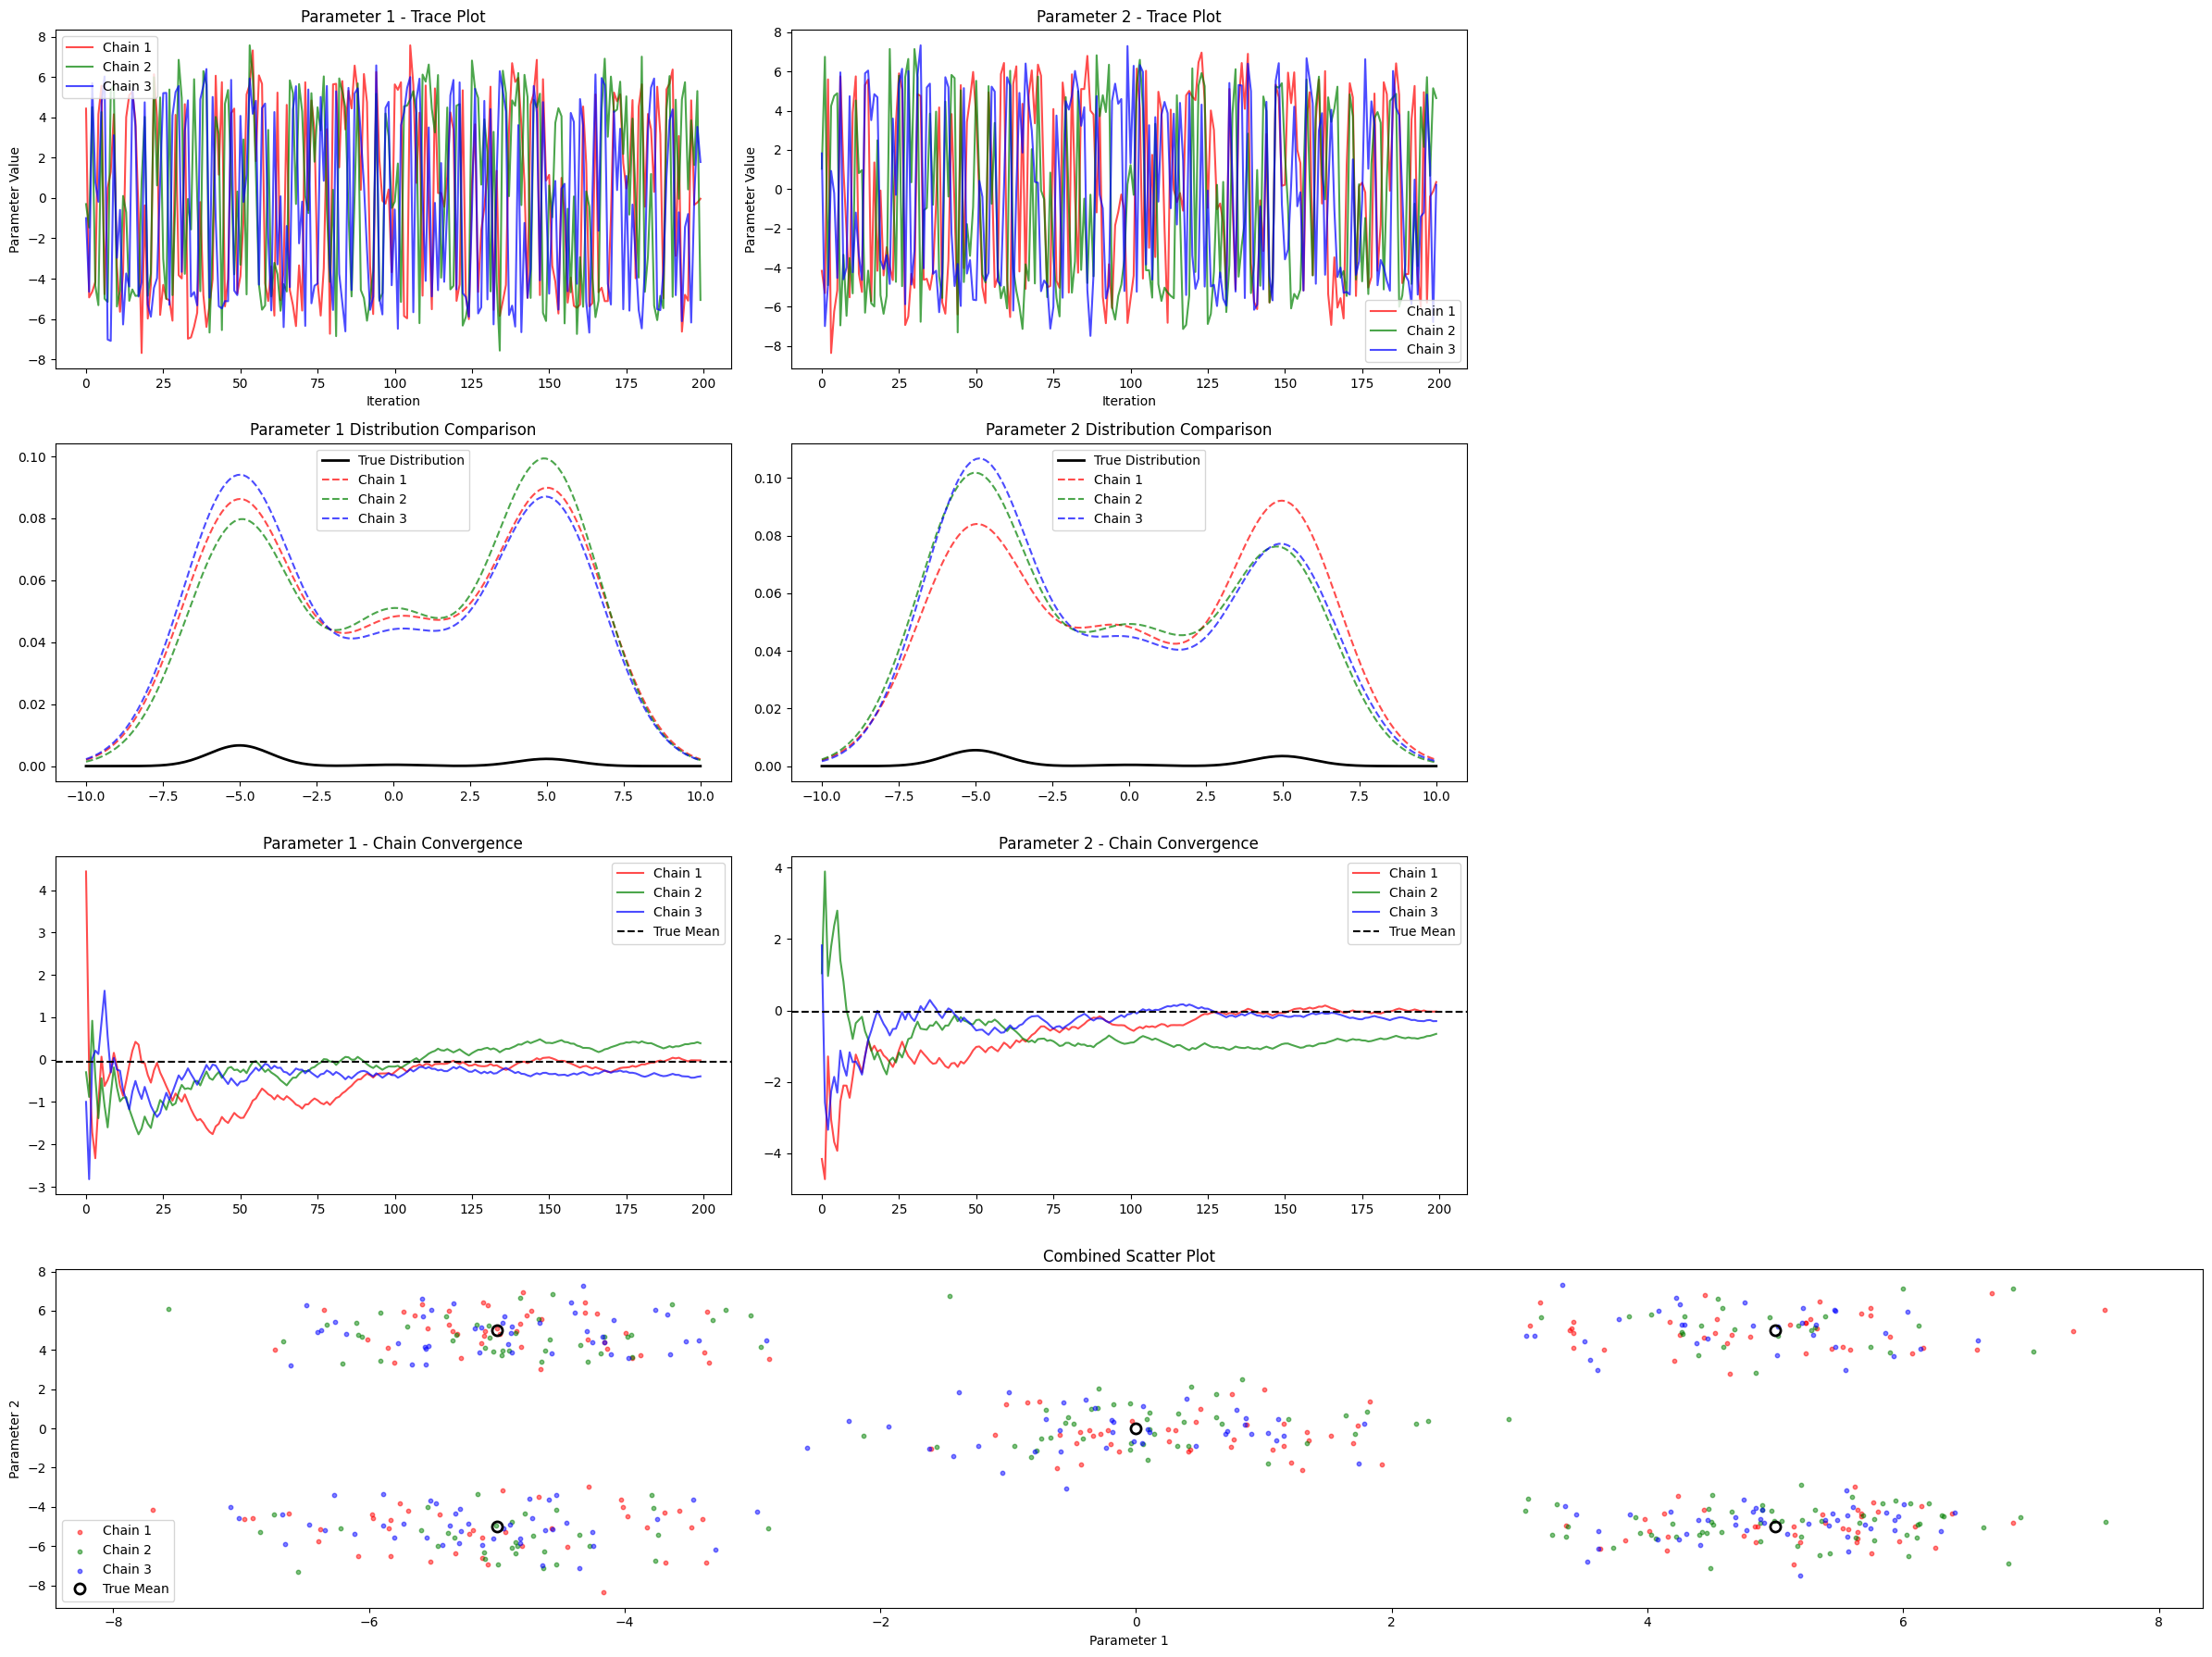

In [3]:
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec
from collections import namedtuple
from scipy.stats import norm
def enhanced_visualization(samples_list, weights_list, means, covariances, weights, titles=None):
    """
    Enhanced visualization for SMC results with:
    1. Separate traceplots for each parameter (two plots)
    2. Distribution comparisons with true distributions
    3. Chain convergence plots
    4. Scatter plot of parameters
    """
    if titles is None:
        titles = [f'Chain {i+1}' for i in range(len(samples_list))]
    
    n_chains = len(samples_list)
    colors = ['r', 'g', 'b']  # Colors for different chains
    
    # 创建更大的画布和更复杂的网格布局
    plt.figure(figsize=(24, 18))
    gs = gridspec.GridSpec(4, 3, width_ratios=[1,1,1], height_ratios=[1,1,1,1])
    
    # 1. Trace plots - Parameter 1
    ax_trace1 = plt.subplot(gs[0, 0])
    for chain_idx in range(n_chains):
        samples = samples_list[chain_idx]
        ax_trace1.plot(samples[:,0], colors[chain_idx]+'-', alpha=0.7, label=titles[chain_idx])
    ax_trace1.legend()
    ax_trace1.set_title('Parameter 1 - Trace Plot')
    ax_trace1.set_xlabel('Iteration')
    ax_trace1.set_ylabel('Parameter Value')
    
    # 2. Trace plots - Parameter 2
    ax_trace2 = plt.subplot(gs[0, 1])
    for chain_idx in range(n_chains):
        samples = samples_list[chain_idx]
        ax_trace2.plot(samples[:,1], colors[chain_idx]+'-', alpha=0.7, label=titles[chain_idx])
    ax_trace2.legend()
    ax_trace2.set_title('Parameter 2 - Trace Plot')
    ax_trace2.set_xlabel('Iteration')
    ax_trace2.set_ylabel('Parameter Value')
    
    # 3. Distribution comparison - Parameter 1
    ax_dist1 = plt.subplot(gs[1, 0])
    x = np.linspace(-10, 10, 200)
    true_pdf = np.zeros_like(x)
    for i in range(len(means)):
        mean = means[i][0]
        cov = covariances[i][0,0]
        true_pdf += weights[i] * norm.pdf(x, mean, np.sqrt(cov))
    ax_dist1.plot(x, true_pdf, 'k-', linewidth=2, label='True Distribution')
    for chain_idx in range(n_chains):
        samples = samples_list[chain_idx]
        weights_chain = weights_list[chain_idx]
        if weights_chain.ndim > 1:
            weights_chain = weights_chain.flatten()
        kde = gaussian_kde(samples[:,0], weights=weights_chain)
        ax_dist1.plot(x, kde(x), colors[chain_idx]+'--', alpha=0.7, label=titles[chain_idx])
    ax_dist1.set_title('Parameter 1 Distribution Comparison')
    ax_dist1.legend()
    
    # 4. Distribution comparison - Parameter 2
    ax_dist2 = plt.subplot(gs[1, 1])
    y = np.linspace(-10, 10, 200)
    true_pdf = np.zeros_like(y)
    for i in range(len(means)):
        mean = means[i][1]
        cov = covariances[i][1,1]
        true_pdf += weights[i] * norm.pdf(y, mean, np.sqrt(cov))
    ax_dist2.plot(y, true_pdf, 'k-', linewidth=2, label='True Distribution')
    for chain_idx in range(n_chains):
        samples = samples_list[chain_idx]
        weights_chain = weights_list[chain_idx]
        if weights_chain.ndim > 1:
            weights_chain = weights_chain.flatten()
        kde = gaussian_kde(samples[:,1], weights=weights_chain)
        ax_dist2.plot(y, kde(y), colors[chain_idx]+'--', alpha=0.7, label=titles[chain_idx])
    ax_dist2.set_title('Parameter 2 Distribution Comparison')
    ax_dist2.legend()
    
    # 5. Chain convergence - Parameter 1
    ax_conv1 = plt.subplot(gs[2, 0])
    for chain_idx in range(n_chains):
        samples = samples_list[chain_idx]
        running_mean = np.cumsum(samples[:,0]) / np.arange(1, len(samples)+1)
        ax_conv1.plot(running_mean, colors[chain_idx]+'-', alpha=0.7, label=titles[chain_idx])
    true_mean = sum(w*m[0] for w, m in zip(weights, means))
    ax_conv1.axhline(true_mean, color='k', linestyle='--', label='True Mean')
    ax_conv1.set_title('Parameter 1 - Chain Convergence')
    ax_conv1.legend()
    
    # 6. Chain convergence - Parameter 2
    ax_conv2 = plt.subplot(gs[2, 1])
    for chain_idx in range(n_chains):
        samples = samples_list[chain_idx]
        running_mean = np.cumsum(samples[:,1]) / np.arange(1, len(samples)+1)
        ax_conv2.plot(running_mean, colors[chain_idx]+'-', alpha=0.7, label=titles[chain_idx])
    true_mean = sum(w*m[1] for w, m in zip(weights, means))
    ax_conv2.axhline(true_mean, color='k', linestyle='--', label='True Mean')
    ax_conv2.set_title('Parameter 2 - Chain Convergence')
    ax_conv2.legend()
    
    # 7. Scatter plot (新增的散点图)
    ax_scatter = plt.subplot(gs[3, :])  # 跨所有列
    for chain_idx in range(n_chains):
        samples = samples_list[chain_idx]
        weights = weights_list[chain_idx]
        if weights.ndim > 1:
            weights = weights.flatten()
        ax_scatter.scatter(samples[:,0], samples[:,1], c=colors[chain_idx], 
                          alpha=0.5, s=10, label=titles[chain_idx])
    for mean in means:
        ax_scatter.plot(mean[0], mean[1], 'ko', markersize=8, markeredgewidth=2,
                       markerfacecolor='none', label='True Mean' if mean is means[0] else "")
    ax_scatter.set_xlabel('Parameter 1')
    ax_scatter.set_ylabel('Parameter 2')
    ax_scatter.set_title('Combined Scatter Plot')
    ax_scatter.legend()
    
    plt.tight_layout()
    plt.show()
def run_smc_with_visualization():
    # 定义数据结构
    NT1 = namedtuple('Options', ['target', 'UB', 'LB', 'N', 'Neff'])
    NT2 = namedtuple('Samples', ['allsamples', 'postval', 'beta', 'stage', 'covsmpl', 'resmpl'])

    dimensions = 2
    means = [np.array([0.0, 0.0]), np.array([5.0, 5.0]), 
             np.array([-5.0, 5.0]), np.array([5.0, -5.0]), 
             np.array([-5.0, -5.0])]
    covariances = [np.eye(dimensions) for _ in range(len(means))]
    weights = [1.0/len(means)] * len(means)

    # 创建概率模型
    log_likelihood = MultiModalNormalLogLikelihood(means, covariances, weights)
    log_prior = pints.UniformLogPrior([-10]*dimensions, [10]*dimensions)
    log_posterior = pints.LogPosterior(log_likelihood, log_prior)

    # 配置SMC参数 - 运行3条不同起点的链
    all_samples = []
    all_weights = []
    
    for chain in range(3):  # 此处参数设置链的个数
        print(f"\nRunning Chain {chain+1}")
        
        # 不同起点
        start_point = np.random.uniform(-8, 8, size=dimensions)
        print(f"Starting point: {start_point}")
        
        opt = NT1(
            target=lambda x: log_posterior(x),
            UB=np.array([10, 10]),
            LB=np.array([-10, -10]),
            N=200,      # 粒子数
            Neff=50     # 每个MCMC阶段迭代次数

        )

        # 运行SMC采样
        initial_samples = NT2(None, None, None, None, None, None)
        final_samples = SMC_samples(opt, initial_samples, NT1, NT2,0.2)

        # 存储结果
        samples = final_samples.allsamples
        weights = np.exp(final_samples.postval - np.max(final_samples.postval))
        weights = weights.flatten()  # 确保权重是一维的
        weights /= np.sum(weights)
        
        all_samples.append(samples)
        all_weights.append(weights)
    
    # 增强可视化（传入所有必需参数）
    enhanced_visualization(all_samples, all_weights, means, 
                         covariances, weights,  # 新增的两个参数
                         titles=['Chain 1', 'Chain 2', 'Chain 3'])
run_smc_with_visualization()